<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
Puzzle Game
</p><br>
<p><a href="https://docs.scipy.org/doc/numpy/reference/">Source: Puzzle Prime (Detective Sanders)</a><br>
I spent a day trying to solve this little enigma. Spoilers below!</p><br>
The goal is to find a 4-digits code hidden in an image, flipped left-to-right:
- find the word spelled on the back side
- rotate the pieces
- rearrange the pieces to form the word
- show the corresponding front side and reveal the secret number

I used the excellent pillow library to work with the image and I borrowed a dictionary from the PyBites challenge to find the hidden word

### Load the images

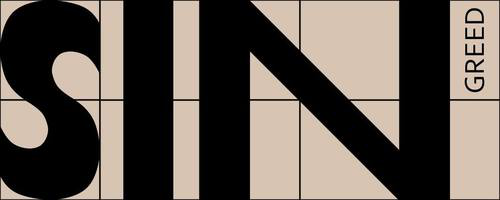

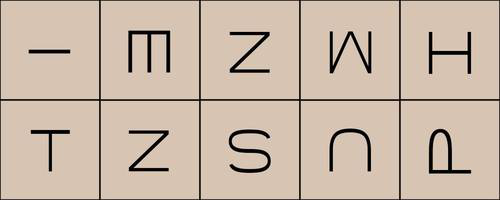

In [4]:
from PIL import Image
img = Image.open('.\SIN+Card+-+front+side.jpg')
img_back=Image.open('.\SIN+Card+-+back+side.jpg')
display(img, img_back)

### Find the word spelled on the back side
I first looked at all the words in the dictionary that contained all the letters (for two of them, I couldn't distinguish whether they were N or Z so I left them apart).<br>
Then I filtered by the size of the word I was looking for (10 letters). So the final list is made from words containing 2 joker letters, either N or something else.

In [2]:
with open('dictionary.txt') as f:
    dic=f.readlines()
dic=[x.replace('\n','') for x in dic]
list_letters=['i','t','e','s','m','u','h','p']
words=[r for r in dic if all(z in r for z in list_letters)]
words_size=[x for x in words if len(x)==10]
words_size

['multiphase', 'punishment', 'unshipment']

Given it is a crime story, 'punishment' seems a perfect fit.

### Cut the image into pieces so they can be rotated and rearranged
First find the image dimensions so we can cut (actually crop) along the partition lines.

In [3]:
img.size

(500, 200)

In [2]:
def crop_pieces(side,order_rotation,order_arrangement):
    dict_crops={}
    for i in order_arrangement:
        upper_lower=0
        left_right=i
        if i>=5:
            upper_lower=100
            left_right=i-5
        dict_crops[i]=side.crop((left_right*100,0+upper_lower,left_right*100+100,100+upper_lower)).rotate(order_rotation[i])
    return dict_crops

The function above takes 3 parameters: 
- side, i.e. which image is fed to it; 
- order_rotation: since the image is flipped left-to-right, the order of rotation is reversed (i.e. flipped by 180 degres) depending on whether we're looking at the back or right side. We'll need to first set the pieces right on the back side, then take this rotation order and remove 180 to each element.
- order_arrangement: the order in which the images are cropped, which will be useful when we reassemble the image later, as we'll reassemble following the order of the word "punishment"

The crop function of the PIL library takes the parameters in the order (left, upper, right, lower).<br>
The rotate function rotates counter-clockwise.
<p>The elements are read left to right and top to bottom by default, 5 pieces at the top and 5 at the bottom, hence the redimensioning when i>=5

### Name the different lists to be fed to the function
This involves two levels of sorting:
- reorder to form the word "punishment" on the back side
- preserve the relationship between the back and front elements

We first reorder and rotate the elements at the back-side of the puzzle.

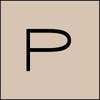

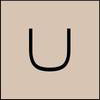

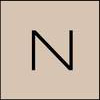

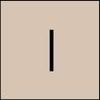

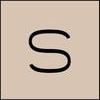

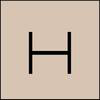

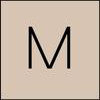

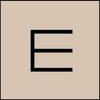

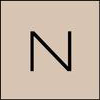

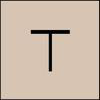

In [5]:
#original_back: we'll name each element according to their letter.
#We suppose that the two "N" appear in the same order in the messed disposition as in the correct one, so we'll name them 1 and 2.
original_back=['I','E','N1','M','H','T','N2','S','U','P']
#Correct order (back side)
correct_order=['P','U','N1','I','S','H','M','E','N2','T']
#Rearrangement of the back side pieces according to the correct order
order=[original_back.index(v) for v in correct_order] #[9,8,2,0,7,4,3,1,6,5]
#order_rotation_back (defined manually from trial-and-error):order in which the elements should be rotated (from the back view).
order_rotation_back=[90,90,90,180,0,0,90,0,180,-90]

cropped_back=crop_pieces(img_back,order_rotation_back,order)
for index in cropped_back:
    display(cropped_back[index])

And now to the front side elements, knowing that we must redefine the order of arrangement to fit the left-to-right relationship between the back and front side.

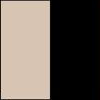

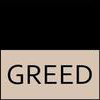

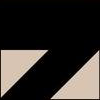

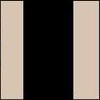

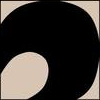

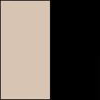

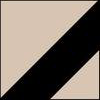

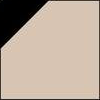

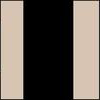

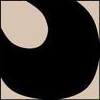

In [6]:
#Since the puzzle is rotated left-to-right, the word will seem to be written right to left from the front-side viewpoint.
relationship_back_front=[4,3,2,1,0,9,8,7,6,5]
#applying relationship back_front to order, i.e. read the elements of relationship_back_front in the order of "order":
original_front=[relationship_back_front.index(v) for v in order] #[5,6,2,4,7,0,1,3,8,9]
#Sort all front elements based on this new order (both the order of the pieces and the order of their rotation)
order_front=sorted(zip(relationship_back_front,original_front,order_rotation_back))
#Retrieve the new order arrangement (and of rotation) for the front side
front = [front for x,front,rotation in order_front] #[7,4,2,6,5,9,8,3,1,0]
rotation_front=[rotation-180 for x,front,rotation in order_front]

cropped_front=crop_pieces(img,rotation_front,front)

for index in cropped_front:
    display(cropped_front[index])

### Reassemble the front side of the image
The easiest method I found was to create a new blank image of the right dimensions, then paste one by one the cropped images in the right order.

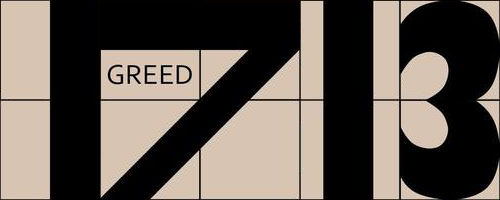

In [8]:
background = Image.new('RGB', (500, 200), (255, 255, 255))
bg_w, bg_h = background.size

def assemble(image,number,layer):
    offset=(number*100,layer)
    background.paste(image, offset)
    return background
nb=0
ly=0
for index in cropped_front:
    if nb>=5:
        ly=100
        nb=nb-5
    assemble(cropped_front[index],nb,ly)
    nb+=1
background

Two possible improvements for a much more challenging game:
- define an algorithm to rotate the pieces based on image recognition (although it will be a guess game for many letters as they are symmetrical)
- reorder the letters automatically to form the word "punishment" based on character recognition.